In [5]:
import os
os.chdir('/home/funkl/defects_DLMBL')

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader
from defects_dlmbl.datamodules import  ISBIDataset, CREMIDataset
from defects_dlmbl.datamodules import CREMIDataModule
import matplotlib.pyplot as plt
from defects_dlmbl import segment_affinities as seg
import numpy as np

In [10]:
dm = CREMIDataModule('/home/funkl/defects_DLMBL/data/training_data.zarr')

In [11]:
dataset = CREMIDataset('/home/funkl/defects_DLMBL/data/training_data.zarr')

In [36]:
dataset[0][2].shape

torch.Size([1, 256, 256])

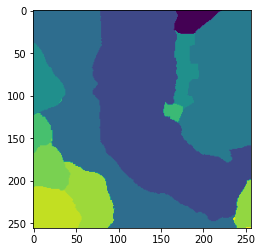

In [37]:
plt.imshow(dataset[0][2][0])

In [38]:
aff=dataset.affinities(dataset[0][2][0].numpy())
aff[1]

array([[-1,  1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1,  1],
       ...,
       [-1,  0,  1, ...,  1,  1,  1],
       [-1,  0,  1, ...,  1,  1,  1],
       [-1,  0,  1, ...,  1,  1,  1]], dtype=int16)

Text(0.5, 1.0, 'Aff')

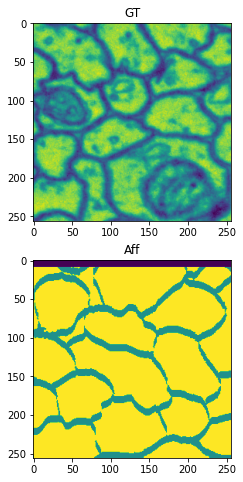

In [40]:
fig, axes = plt.subplots(2, figsize=(15, 8))
axes[0].imshow(dataset[0][0].squeeze())
axes[0].set_title('GT')
axes[1].imshow(aff[2])
axes[1].set_title('Aff')  

In [16]:
# affs = np.stack([
# np.zeros_like(aff[0]),
# aff[1],
# aff[0]])

# # waterz agglomerate requires 4d affs (c, d, h, w) - add fake z dim
# affs = np.expand_dims(affs, axis=1)
# affs

array([[[[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]]],


       [[[-1, -1,  1, ...,  1,  1,  1],
         [-1, -1,  1, ...,  1,  1,  1],
         [-1, -1,  1, ...,  1,  1,  1],
         ...,
         [-1, -1,  1, ...,  1,  0,  1],
         [-1, -1,  1, ...,  1,  1,  1],
         [-1, -1,  1, ...,  1,  1,  1]]],


       [[[-1, -1, -1, ..., -1, -1, -1],
         [-1,  1,  1, ...,  1,  1,  1],
         [-1,  1,  1, ...,  1,  1,  1],
         ...,
         [-1,  1,  1, ...,  1,  0,  1],
         [-1,  1,  1, ...,  0,  1,  1],
         [-1,  1,  1, ...,  1,  1,  1]]]], dtype=int16)

In [41]:
aff.shape

(4, 256, 256)

In [42]:
offsets = [[-1,0],[0,-1],[-9,0],[0,-9]]

In [52]:
testseg = seg.mutex_watershed(aff.astype(np.float),offsets)
testseg = testseg.astype(np.uint64)
testseg.max()

/tmp/ipykernel_26099/2003369790.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  testseg = seg.mutex_watershed(aff.astype(np.float),offsets)


41

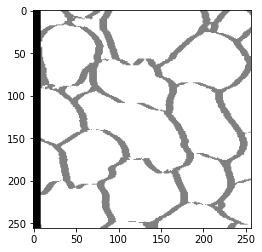

In [55]:
plt.imshow(aff[3],cmap='gray')

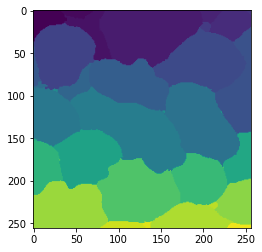

In [54]:
plt.imshow(testseg.squeeze())

In [11]:
np.max(aff)

True

In [22]:
import waterz
from scipy.ndimage import label
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes
import numpy as np


def watershed_from_boundary_distance(
        boundary_distances,
        boundary_mask,
        return_seeds=False,
        id_offset=0,
        min_seed_distance=10):

    max_filtered = maximum_filter(boundary_distances, min_seed_distance)
    maxima = max_filtered==boundary_distances
    seeds, n = label(maxima)
    plt.imshow(seeds)
    print(f"Found {n} fragments")

    if n == 0:
        return np.zeros(boundary_distances.shape, dtype=np.uint64), id_offset

    seeds[seeds!=0] += id_offset

    fragments = watershed(
        boundary_distances.max() - boundary_distances,
        seeds)

    ret = (fragments.astype(np.uint64), n + id_offset)
    if return_seeds:
        ret = ret + (seeds.astype(np.uint64),)

    return ret


def watershed_from_affinities(
        affs,
        max_affinity_value=1.0,
        fragments_in_xy=True,
        return_seeds=False,
        min_seed_distance=10,
        labels_mask=None):

    mean_affs = (affs[1] + affs[2])>0.5
    depth = mean_affs.shape[0]

    fragments = np.zeros(mean_affs.shape, dtype=np.uint64)
    if return_seeds:
        seeds = np.zeros(mean_affs.shape, dtype=np.uint64)

    id_offset = 0

    for z in range(depth):

        boundary_mask = mean_affs[z]>0.5*max_affinity_value
        boundary_distances = distance_transform_edt(boundary_mask)
        plt.imshow(boundary_distances.squeeze())
        if labels_mask is not None:

            boundary_mask *= labels_mask.astype(bool)

        ret = watershed_from_boundary_distance(
            boundary_distances,
            boundary_mask,
            return_seeds=return_seeds,
            id_offset=id_offset,
            min_seed_distance=min_seed_distance)

        fragments[z] = ret[0]
        if return_seeds:
            seeds[z] = ret[2]

        id_offset = ret[1]

    ret = (fragments)
    if return_seeds:
        ret += (seeds,)

    return ret



# utility function to agglomerate fragments using underlying affinities as edge weights
# returns a segmentation from a final threshold

def get_segmentation(affinities, threshold=.5, labels_mask=None):
    threshold=threshold
    
    fragments = watershed_from_affinities(
            affinities,
            labels_mask=labels_mask)[0]

    thresholds = [threshold]

    generator = waterz.agglomerate(
        affs=affinities.astype(np.float32),
        fragments=fragments,
        thresholds=thresholds,
    )

    segmentation = next(generator)

    
    # remove small holes and relabel connected components
    final_seg, _ = label(
            remove_small_holes(
            segmentation.astype(bool),
            area_threshold=256))

    final_seg = final_seg.astype(np.uint64)

    return final_seg



Found 45 fragments
Re-using already compiled waterz version
Preparing segmentation volume...


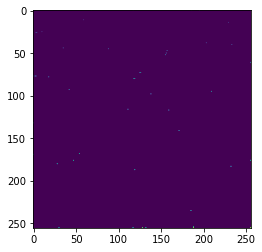

In [23]:
testseg = get_segmentation(affs.astype(np.float), .3)
testseg = testseg.astype(np.uint64)

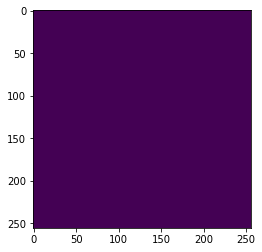

In [24]:
plt.imshow(testseg[0].squeeze())

Found 45 fragments


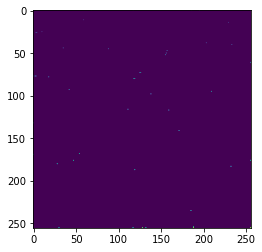

In [25]:
af=watershed_from_affinities(affs)

In [26]:
af

(array([[[10,  1,  1, ...,  6,  6,  6],
         [10, 10,  1, ...,  6,  6,  6],
         [10, 10, 10, ...,  6,  6,  6],
         ...,
         [41, 41, 41, ..., 45, 45, 45],
         [41, 41, 41, ..., 45, 45, 45],
         [41, 41, 41, ..., 45, 45, 45]]], dtype=uint64),
 45)

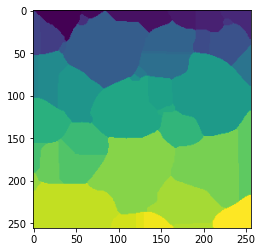

In [29]:
plt.imshow(af[0].squeeze())